# Optimizer for Call Center Model with delays 

Customers always enter in the first slot of the server 

In [1]:
using JuMP
using HiGHS
using Juniper

include("utils.jl") # demand_generator_mat, df_input_generator, printTable, plotData

plotData (generic function with 1 method)

## Initial parameters definition

In [356]:
# Objective function Costs
c_cin = 1.5        # weight of served clients
c_ser = 2      # weight of server cost  
c_L = 1.5
c_phi = 1

# # Objective function
# fobj_om(S, dr, Cin, phi, Z, L) = sum(dr) + c_ser*sum(S) - c_cin*sum(Cin) - c_phi*sum(phi)

fobj_om(S, dr, Cin, phi, Z, L) = c_ser*sum(S) - c_cin*sum(Z) +c_phi*sum(L)


fobj_os(S, dr, Cin, phi, Z, L) = c_ser*S -c_cin*Z + c_L*L


# Parameters
horiz = 30        # total horizon

# bounds
YM = 10           # max buffer legnth before dropping calls
XM = 6            # max queue length 
phiM = 10          # max adimission to queue
serM = 8          # number of servers
tserM = 3         # max service time

# iniital conditions
X0 = 3
Y0 = 2
L0 = 0
Z0 = 0

struct initial_conditions
    X0
    Y0
    L0
    Z0
end
ic = initial_conditions(X0, Y0, L0, Z0)

struct bounds
    XM
    YM
    phiM
    serM
end
bds = bounds(XM, YM, phiM, serM)

rnd_tser = true
df_input = df_input_generator(horiz, serM, tserM, rnd_tser)

createDemands = true
if createDemands
    d_mat = demand_generator_mat(1, 30, 7, "uniform", 1)
    a_mat = demand_generator_mat(1, 30, 1,"uniform",0.5)
else
    d_fn = "..//CC_simple//d_mat_Thu_22_May_2025_19_39_50.txt";
    a_fn = "..//CC_simple//a_mat_Thu_22_May_2025_19_39_50.txt";
    d_mat = DelimitedFiles.readdlm(d_fn);
    a_mat = DelimitedFiles.readdlm(a_fn);
    
end

d = d_mat[1:horiz, 1];  # demand for incoming calls
a = a_mat[1:horiz, 1];  # abandonment for calls
   

std_dev = 1 # standard deviation for the random abandonment


1

## One-step-ahead Optimization with $\phi$ as control variable

Number of active servers is constant and equal to max.

List of variables modified by $\phi(k)$:

- $n(k)$
- $q(k)$
- $dr(k)$
- $Y(k+1)$
- $X(k+1)$
- $L(k+1)$


Objective function: maximize $f(k)$

$f(k) = \phi(k) - L(k+1)$

In [335]:
# function optimize_cc_os_delay_0(ic, bds, a, d, df_input, fobj)
#     horiz = length(d)
#     optimal = false

#     J = zeros(horiz)            # cost function
#     X = zeros(Int, horiz+1)     # current number of customers in queue x(k)
#     Y = zeros(Int, horiz+1)     # current number of customers in buffer y(k)  
#     Z = zeros(Int, horiz+1)     # custumers served  
#     L = zeros(Int, horiz+1)     # number of customers lost

#     n = zeros(Int, horiz+1)     # number of empty slots in the queue
#     Q = zeros(Int, horiz+1)     # custumers entering queue
#     dr = zeros(Int, horiz+1)    # dropped due to full buffer

#     phi = zeros(Int, horiz+1)     # number of customers admitted to queue
#     Cin = zeros(Int, horiz+1)     # number of customers entering server
#     Cout = zeros(Int, horiz+1)    # number of customers leaving server

#     S = zeros(Int, horiz+1)                 # number of active servers
#     Sl = zeros(Int, horiz+1)                # number of free servers
#     Sst = zeros(Bool, horiz+1, serM)        # server status (0 - free, 1 - busy)
#     Sc = zeros(Bool, horiz+1, serM, tserM)  # server conveyor
#     Sin = zeros(Bool, horiz+1, serM, tserM) # server input

#     Saux = zeros(Bool, horiz+1, serM)       # auxiliary server variable
#     b1_opt = zeros(horiz)
#     b2_opt = zeros(horiz)

#     B = zeros(Float64, horiz+1)                # balking rate

#     # initial conditions
#     X[1] = X0
#     Y[1] = Y0
#     L[1] = L0
#     Z[1] = Z0

#     transition_matrix = zeros(Bool, tserM, tserM)
#     for i in 1:tserM-1
#         transition_matrix[i, i+1] = 1
#     end


#     for t in 1:horiz
#         cc_os_delay = Model(HiGHS.Optimizer)
#         set_silent(cc_os_delay)
    
#         # a[t] = min(X[t], max(0, Int.(round.(X[t]/4 .+ rand(Normal(0, std_dev))))))
    
#         M1 = max(d[t], YM) + 10; # must be larger than d[t] and n[t] 
#         @variable(cc_os_delay, b1, Bin);
    
#         M2 = max(X[t], serM) + 10; # must be larger than x[k] and Sl[k]
#         @variable(cc_os_delay, b2, Bin);
    
#         @variable(cc_os_delay, 0 <= XL[1:2] <= XM, Int)    
#         @variable(cc_os_delay, 0 <= YL[1:2] <= YM, Int)     
#         @variable(cc_os_delay, 0 <= ZL[1:2], Int)  
#         @variable(cc_os_delay, 0 <= LL[1:2], Int)         
                               
#         @variable(cc_os_delay, 0 <= nL <= YM, Int) 
#         @variable(cc_os_delay, 0 <= QL, Int)      
#         @variable(cc_os_delay, 0 <= drL, Int)   
        
#         @variable(cc_os_delay, 0 <= phiL <= phiM, Int)   
#         @variable(cc_os_delay, 0 <= CinL <= serM, Int)   
#         @variable(cc_os_delay, 0 <= CoutL[1:2] <= serM, Int)    
    
#         @variable(cc_os_delay, 0 <= SL <= serM, Int)  
#         @variable(cc_os_delay, 0 <= SlL <= serM, Int)  
#         @variable(cc_os_delay, 0 <= SstL[1:serM], Bin)  
#         @variable(cc_os_delay, 0 <= ScL[1:2, 1:serM, 1:tserM], Bin) 
#         @variable(cc_os_delay, 0 <= SinL[1:serM, 1:tserM], Bin)
#         @variable(cc_os_delay, 0 <= SauxL[1:serM], Bin)
    
#         # @variable(cc_os_delay, 0 <= BL)  
            
#         # Initial conditions of buffer and queue for each optimization
#         @constraint(cc_os_delay, XL[1] == X[t])
#         @constraint(cc_os_delay, YL[1] == Y[t])
#         @constraint(cc_os_delay, ZL[1] == Z[t])
#         @constraint(cc_os_delay, LL[1] == L[t])
#         @constraint(cc_os_delay, CoutL[1] == Cout[t])
#         @constraint(cc_os_delay, ScL[1, :, :] == Sc[t, :, :])  # server conveyor status
    
#         # Problem constraints  
#         @constraint(cc_os_delay, XL[2] == XL[1] + phiL - a[t] - CinL)
#         @constraint(cc_os_delay, YL[2] == YL[1] + QL - phiL)
#         @constraint(cc_os_delay, ZL[2] == ZL[1] + CinL)
#         @constraint(cc_os_delay, LL[2] == LL[1] + drL + a[t])
    
#         @constraint(cc_os_delay, nL == YM - YL[1] + phiL)  # number of empty slots in the queue
#         @constraint(cc_os_delay, QL <= d[t])
#         @constraint(cc_os_delay, QL <= nL)
#         @constraint(cc_os_delay, QL >= d[t]-M1*b1)
#         @constraint(cc_os_delay, QL >= nL-(1-b1)*M1)  
    
#         @constraint(cc_os_delay, drL >= d[t]-nL)         
#         @constraint(cc_os_delay, drL <= d[t]-QL) 
    
#         @constraint(cc_os_delay, SL == serM)              
#         @constraint(cc_os_delay, SstL == sum(ScL[1,:,:], dims=2))  
#         @constraint(cc_os_delay, SlL == SL - sum(SstL))    
#         @constraint(cc_os_delay, [i=1:serM, j=1:tserM], SinL[i, j] == df_input[t, i, j] .* SauxL[i])
#         @constraint(cc_os_delay, ScL[2, :, :] == ScL[1, :, :]*transition_matrix + SinL)
    
#         @constraint(cc_os_delay, CinL <= XL[1]-a[t])
#         @constraint(cc_os_delay, CinL <= SlL)
#         @constraint(cc_os_delay, CinL >= XL[1]-a[t]-M2*b2)
#         @constraint(cc_os_delay, CinL >= SlL-(1-b2)*M2)  
#         @constraint(cc_os_delay, CoutL[2] == sum(ScL[1,:,tserM]))  
    
#         @constraint(cc_os_delay, SauxL <= ones(Bool, serM) - SstL)  
#         @constraint(cc_os_delay, CinL == sum(SauxL))  
    
#         # Objective function
#         @expression(cc_os_delay, expr, fobj(SL, drL, CinL, phiL, ZL[2], LL[2])) 
#         @objective(cc_os_delay, Min, expr)
        
#         JuMP.optimize!(cc_os_delay)
        
#         status = termination_status(cc_os_delay)
#         if (status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED || status==MOI.ALMOST_LOCALLY_SOLVED) && has_values(cc_os_delay)
#             # Save computed values
#             X[t+1] = JuMP.value(XL[2]);
#             Y[t+1] = JuMP.value(YL[2]);
#             Z[t+1] = JuMP.value(ZL[2]);
#             L[t+1] = JuMP.value(LL[2]);
    
#             n[t] = JuMP.value(nL);
#             Q[t] = JuMP.value(QL);  
#             dr[t] = JuMP.value(drL);
            
#             phi[t] = JuMP.value(phiL);
#             Cin[t] = JuMP.value(CinL);
#             Cout[t+1] = JuMP.value(CoutL[2]);
    
#             S[t] = JuMP.value(SL);
#             Sl[t] = JuMP.value(SlL);
#             Sst[t, :] = JuMP.value.(SstL);
#             Sc[t+1, :, :] = JuMP.value.(ScL[2, :, :]);
#             Sin[t, :, :] = JuMP.value.(SinL);
#             Saux[t, :] = JuMP.value.(SauxL);
    
#             b1_opt[t] = JuMP.value(b1);
#             b2_opt[t] = JuMP.value(b2);
    
#             J[t] = objective_value(cc_os_delay) 
            
#             optimal = true
#             # Display results
#             # println("Optimal solution:")
#             # println("Objective value = ", objective_value(cc_os_delay))
#         else
#             optimal = false
#             println(t, " ", status)
#             break
#         end
#     end

#     return optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J

# end

In [336]:
# optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J = optimize_cc_os_delay_0(ic, bds, a, d, df_input, fobj_os, c_ser);

# Z_os0 = Z[horiz+1]
# L_os0 = L[horiz+1]
# J_os0 = sum(J)

In [337]:
# data = hcat(1:horiz, d, dr[1:horiz,1], n[1:horiz,1], Q[1:horiz,1], Y[1:horiz,1], phi[1:horiz, 1], X[1:horiz,1], Cin[1:horiz,1], Cout[1:horiz,1], a)
# header = (["t", "d", "dr", "n", "q", "Y", "phi", "X", "Cin", "Cout", "a"]);
# printTable(data, header)

In [338]:
# evolution = [X[1:horiz,1], Cin[1:horiz,1], S[1:horiz,1], L[1:horiz,1]]
# ylabel = [L"X" L"C_{in}" L"S" L"dr"]
# title = ["queue occupancy" "served customers" "active servers" "lost customers"]

# plotData(evolution, ylabel, title)

In [339]:
# println("Total number of served customers: ", Z[horiz+1])
# println("Total number of lost customers: ", L[horiz+1])
# println("Total cost: ", sum(J))

## One-step-ahead Optimization with $\phi$ and S as control variables

List of variables modified by $\phi(k)$:
- $n[k]$
- $q[k]$
- $dr[k]$
- $Y[k+1]$
- $X[k+1]$
- $L[k+1]$

List of variables modified by $S(k)$:
- $S_l[k]$
- $S_{aux}[k]$
- $S_{in}[k]$
- $C_{in}[k]$
- $S_c[k+1]$
- $\phi[k]$
s
Objective function: min $f[x]$

Objective function should only use the variables that are modified by $\phi[k]$ and $S[k]$.

$ f[k] = L[k+1] + c_{ser}\cdot S[k] - c_{cin}\cdot Cin[k] - \phi[k] $

Is there a reason not to always use maximum $\phi$?

In [307]:
function optimize_cc_os_delay_1(ic, bds, a, d, df_input, fobj)
    horiz = length(d)  
    optimal = false
    
    # bounds
    XM = bds.XM
    YM = bds.YM     
    phiM = bds.phiM
    serM = bds.serM

    J = zeros(horiz)            # cost function
    X = zeros(Int, horiz+1)     # current number of customers in queue x(k)S
    Y = zeros(Int, horiz+1)     # current number of customers in buffer y(k)  
    Z = zeros(Int, horiz+1)     # custumers served  
    L = zeros(Int, horiz+1)     # number of customers lost

    n = zeros(Int, horiz+1)     # number of empty slots in the queue
    Q = zeros(Int, horiz+1)     # custumers entering queue
    dr = zeros(Int, horiz+1)    # dropped due to full buffer

    phi = zeros(Int, horiz+1)     # number of customers admitted to queue
    Cin = zeros(Int, horiz+1)     # number of customers entering server
    Cout = zeros(Int, horiz+1)    # number of customers leaving server

    S = zeros(Int, horiz+1)                 # number of active servers
    Sa = zeros(Bool, horiz+1, serM)         # server activation status (0 - active, 1 - inactive)
    Sl = zeros(Int, horiz+1)                # number of free available servers
    Sst = zeros(Bool, horiz+1, serM)        # server status (0 - free, 1 - busy)
    Sc = zeros(Bool, horiz+1, serM, tserM)  # server conveyor
    Sin = zeros(Bool, horiz+1, serM, tserM) # server input

    Saux = zeros(Bool, horiz+1, serM)       # auxiliary server variable
    b1_opt = zeros(horiz)
    b2_opt = zeros(horiz)

    B = zeros(Float64, horiz+1)             # balking rate

    transition_matrix = zeros(Bool, tserM, tserM)
    for i in 1:tserM-1
        transition_matrix[i, i+1] = 1
    end

    # initial conditions
    X[1] = ic.X0
    Y[1] = ic.Y0
    L[1] = ic.L0
    Z[1] = ic.Z0

    for t in 1:horiz
        cc_os_delay = Model(HiGHS.Optimizer)
        set_silent(cc_os_delay)

        # a[t] = min(X[t], max(0, Int.(round.(X[t]/4 .+ rand(Normal(0, std_dev))))))

        M1 = max(d[t], YM) + 10; # must be larger than d[t] and n[t] 
        @variable(cc_os_delay, b1, Bin);

        M2 = max(X[t], serM) + 10; # must be larger than x[k] and Sl[k]
        @variable(cc_os_delay, b2, Bin);

        @variable(cc_os_delay, 0 <= XL[1:2] <= XM, Int)    
        @variable(cc_os_delay, 0 <= YL[1:2] <= YM, Int)     
        @variable(cc_os_delay, 0 <= ZL[1:2], Int)  
        @variable(cc_os_delay, 0 <= LL[1:2], Int)         
                            
        @variable(cc_os_delay, 0 <= nL <= YM, Int) 
        @variable(cc_os_delay, 0 <= QL, Int)      
        @variable(cc_os_delay, 0 <= drL, Int)   
        
        @variable(cc_os_delay, 0 <= phiL <= phiM, Int)   
        @variable(cc_os_delay, 0 <= CinL <= serM, Int)   
        @variable(cc_os_delay, 0 <= CoutL[1:2] <= serM, Int)    

        @variable(cc_os_delay, 0 <= SL <= serM, Int)  
        @variable(cc_os_delay, 0 <= SaL[1:serM], Bin)
        @variable(cc_os_delay, 0 <= SlL <= serM, Int)  
        @variable(cc_os_delay, 0 <= SstL[1:serM], Bin)  
        @variable(cc_os_delay, 0 <= ScL[1:2, 1:serM, 1:tserM], Bin) 
        @variable(cc_os_delay, 0 <= SinL[1:serM, 1:tserM], Bin)
        @variable(cc_os_delay, 0 <= SauxL[1:serM], Bin)

        # Initial conditions of buffer and queue for each optimization
        @constraint(cc_os_delay, XL[1] == X[t])
        @constraint(cc_os_delay, YL[1] == Y[t])
        @constraint(cc_os_delay, ZL[1] == Z[t])
        @constraint(cc_os_delay, LL[1] == L[t])
        @constraint(cc_os_delay, CoutL[1] == Cout[t])
        @constraint(cc_os_delay, ScL[1, :, :] == Sc[t, :, :])  # server conveyor status

        # Problem constraints  
        @constraint(cc_os_delay, XL[2] == XL[1] + phiL - a[t] - CinL)
        @constraint(cc_os_delay, YL[2] == YL[1] + QL - phiL)
        @constraint(cc_os_delay, ZL[2] == ZL[1] + CinL)
        @constraint(cc_os_delay, LL[2] == LL[1] + drL + a[t])

        @constraint(cc_os_delay, nL == YM - YL[1] + phiL)  # number of empty slots in the queue
        @constraint(cc_os_delay, QL <= d[t])
        @constraint(cc_os_delay, QL <= nL)
        @constraint(cc_os_delay, QL >= d[t]-M1*b1)
        @constraint(cc_os_delay, QL >= nL-(1-b1)*M1)  

        @constraint(cc_os_delay, drL >= d[t]-nL)         
        @constraint(cc_os_delay, drL <= d[t]-QL) 

        @constraint(cc_os_delay, SL == serM - sum(SaL))              
        @constraint(cc_os_delay, SstL == sum(ScL[1,:,:], dims=2))  
        @constraint(cc_os_delay, SlL == SL - sum(SstL))    
        @constraint(cc_os_delay, [i=1:serM, j=1:tserM], SinL[i, j] == df_input[t, i, j] .* SauxL[i])
        @constraint(cc_os_delay, ScL[2, :, :] == ScL[1, :, :]*transition_matrix + SinL)

        # @constraint(cc_os_delay, CinL <= XL[1]-a[t])
        @constraint(cc_os_delay, CinL <= SlL)
        # @constraint(cc_os_delay, CinL >= XL[1]-a[t]-M2*b2)
        # @constraint(cc_os_delay, CinL >= SlL-(1-b2)*M2)  
        @constraint(cc_os_delay, CoutL[2] == sum(ScL[1,:,tserM]))  

        @constraint(cc_os_delay, SauxL <= ones(Bool, serM) - SstL - SaL)  
        @constraint(cc_os_delay, CinL == sum(SauxL))  

        # Objective function
        @expression(cc_os_delay, expr, fobj(SL, drL, CinL, phiL, ZL[2], LL[2])) 
        @objective(cc_os_delay, Min, expr)

        JuMP.optimize!(cc_os_delay)
        
        status = termination_status(cc_os_delay)
        if (status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED || status==MOI.ALMOST_LOCALLY_SOLVED) && has_values(cc_os_delay)
            # Save computed values
            X[t+1] = JuMP.value(XL[2]);
            Y[t+1] = JuMP.value(YL[2]);
            Z[t+1] = JuMP.value(ZL[2]);
            L[t+1] = JuMP.value(LL[2]);

            n[t] = JuMP.value(nL);
            Q[t] = JuMP.value(QL);  
            dr[t] = JuMP.value(drL);
            
            phi[t] = JuMP.value(phiL);
            Cin[t] = JuMP.value(CinL);
            Cout[t+1] = JuMP.value(CoutL[2]);

            S[t] = JuMP.value(SL);
            Sl[t] = JuMP.value(SlL);
            Sst[t, :] = JuMP.value.(SstL);
            Sc[t+1, :, :] = JuMP.value.(ScL[2, :, :]);
            Sin[t, :, :] = JuMP.value.(SinL);
            Saux[t, :] = JuMP.value.(SauxL);

            b1_opt[t] = JuMP.value(b1);
            b2_opt[t] = JuMP.value(b2);

            J[t] = objective_value(cc_os_delay)

            optimal = true;
            # Display results
            # println("Optimal solution:")
            # println("Objective value = ", objective_value(cc_os_delay))
        else
            optimal = false;
            println(t, " ", status)
            break
        end
    end

    return optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J

end

optimize_cc_os_delay_1 (generic function with 1 method)

In [320]:
optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J = optimize_cc_os_delay_1(ic, bds, a, d, df_input, fobj_os);

Z_os1 = Z[horiz+1]
L_os1 = L[horiz+1]
J_os1 = sum(J)


-94.0

In [321]:
data = hcat(1:horiz, d, dr[1:horiz,1], n[1:horiz,1], Q[1:horiz,1], Y[1:horiz,1], phi[1:horiz, 1], X[1:horiz,1], S[1:horiz,1], Cin[1:horiz,1], Cout[1:horiz,1], a)
header = (["t", "d", "dr", "n", "q", "Y", "phi", "X", "S", "Cin", "Cout", "a"]);
printTable(data, header)

Results
┌────────┬───────┬───────┬────────┬───────┬────────┬───────┬───────┬───────┬───────┬───────┬─────┐
│      t │     d │    dr │      n │     q │      Y │   phi │     X │     S │   Cin │  Cout │   a │
├────────┼───────┼───────┼────────┼───────┼────────┼───────┼───────┼───────┼───────┼───────┼─────┤
│  1.000 │ 4.000 │ 0.000 │ 10.000 │ 4.000 │  2.000 │ 2.000 │ 3.000 │ 0.000 │ 0.000 │ 0.000 │ 1.0 │
│  2.000 │ 4.000 │ 0.000 │  6.000 │ 4.000 │  4.000 │ 0.000 │ 4.000 │ 0.000 │ 0.000 │ 0.000 │ 0.0 │
│  3.000 │ 2.000 │ 0.000 │  2.000 │ 2.000 │  8.000 │ 0.000 │ 4.000 │ 0.000 │ 0.000 │ 0.000 │ 1.0 │
│  4.000 │ 6.000 │ 0.000 │  6.000 │ 6.000 │ 10.000 │ 6.000 │ 3.000 │ 2.000 │ 2.000 │ 0.000 │ 1.0 │
│  5.000 │ 3.000 │ 0.000 │  3.000 │ 3.000 │ 10.000 │ 3.000 │ 6.000 │ 5.000 │ 3.000 │ 0.000 │ 0.0 │
│  6.000 │ 3.000 │ 0.000 │  3.000 │ 3.000 │ 10.000 │ 3.000 │ 6.000 │ 6.000 │ 2.000 │ 1.000 │ 1.0 │
│  7.000 │ 6.000 │ 3.000 │  3.000 │ 3.000 │ 10.000 │ 3.000 │ 6.000 │ 8.000 │ 2.000 │ 0.000 │ 1.0 │
│ 

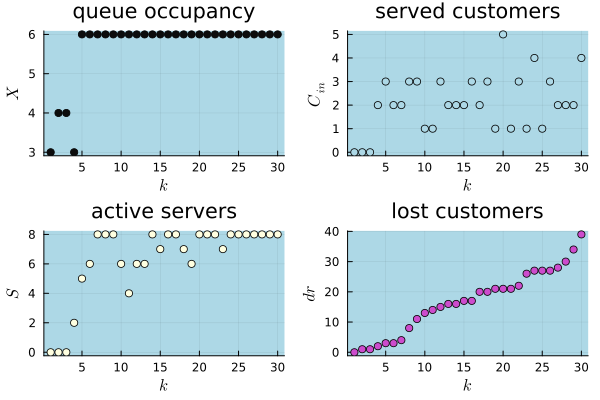

In [322]:
evolution = [X[1:horiz,1], Cin[1:horiz,1], S[1:horiz,1], L[1:horiz,1]]
ylabel = [L"X" L"C_{in}" L"S" L"dr"]
title = ["queue occupancy" "served customers" "active servers" "lost customers"]

plotData(evolution, ylabel, title)

In [342]:
println("Total number of served customers: ", Z[horiz+1])
println("Total number of lost customers: ", L[horiz+1])
println("Total value obj func: ", sum(J))

println("Balking rate: ", sum(L)/sum(L+Z))
println("Total numer of servers used: ", sum(S))

print("c_ser*S + c_blr*B = ", sum(S) + 140*sum(L)/sum(L+Z))


Total number of served customers: 63
Total number of lost customers: 40
Total value obj func: -94.0
Balking rate: 0.38746438746438744
Total numer of servers used: 190
c_ser*S + c_blr*B = 244.24501424501426

# Omniscient Optimization

Using $S[k]$ and $\phi[k]$ as control variables

In [361]:
function optimize_cc_om_delay(ic, bds, a, d, df_input, fobj)
    horiz = length(d)  
    optimal = false

    # bounds
    XM = bds.XM
    YM = bds.YM     
    phiM = bds.phiM
    serM = bds.serM

    J = zeros(horiz)            # cost function
    X = zeros(Int, horiz+1)     # current number of customers in queue x(k)S
    Y = zeros(Int, horiz+1)     # current number of customers in buffer y(k)  
    Z = zeros(Int, horiz+1)     # custumers served  
    L = zeros(Int, horiz+1)     # number of customers lost

    n = zeros(Int, horiz+1)     # number of empty slots in the queue
    Q = zeros(Int, horiz+1)     # custumers entering queue
    dr = zeros(Int, horiz+1)    # dropped due to full buffer

    phi = zeros(Int, horiz+1)     # number of customers admitted to queue
    Cin = zeros(Int, horiz+1)     # number of customers entering server
    Cout = zeros(Int, horiz+1)    # number of customers leaving server

    S = zeros(Int, horiz+1)                 # number of active servers
    Sa = zeros(Bool, horiz+1, serM)         # server activation status (0 - active, 1 - inactive)
    Sl = zeros(Int, horiz+1)                # number of free available servers
    Sst = zeros(Bool, horiz+1, serM)        # server status (0 - free, 1 - busy)
    Sc = zeros(Bool, horiz+1, serM, tserM)  # server conveyor
    Sin = zeros(Bool, horiz+1, serM, tserM) # server input

    Saux = zeros(Bool, horiz+1, serM)       # auxiliary server variable
    b1_opt = zeros(horiz)
    b2_opt = zeros(horiz)

    B = zeros(Float64, horiz+1)             # balking rate

    transition_matrix = zeros(Bool, tserM, tserM)
    for i in 1:tserM-1
        transition_matrix[i, i+1] = 1
    end

    # initial conditions
    X[1] = ic.X0
    Y[1] = ic.Y0
    L[1] = ic.L0
    Z[1] = ic.Z0

    cc_om_delay = Model(HiGHS.Optimizer)
    set_silent(cc_om_delay)

    @variable(cc_om_delay, b1[1:horiz], Bin);
    @variable(cc_om_delay, b2[1:horiz], Bin);

    @variable(cc_om_delay, 0 <= XL[1:horiz+1] <= XM, Int)    
    @variable(cc_om_delay, 0 <= YL[1:horiz+1] <= YM, Int)     
    @variable(cc_om_delay, 0 <= ZL[1:horiz+1], Int)  
    @variable(cc_om_delay, 0 <= LL[1:horiz+1], Int)         
                            
    @variable(cc_om_delay, 0 <= nL[1:horiz+1] <= YM, Int) 
    @variable(cc_om_delay, 0 <= QL[1:horiz+1], Int)      
    @variable(cc_om_delay, 0 <= drL[1:horiz+1], Int)   
        
    @variable(cc_om_delay, 0 <= phiL[1:horiz+1] <= phiM, Int)   
    @variable(cc_om_delay, 0 <= CinL[1:horiz+1] <= serM, Int)   
    @variable(cc_om_delay, 0 <= CoutL[1:horiz+1] <= serM, Int)    

    @variable(cc_om_delay, 0 <= SL[1:horiz+1] <= serM, Int)  
    @variable(cc_om_delay, 0 <= SaL[1:horiz+1, 1:serM], Bin)
    @variable(cc_om_delay, 0 <= SlL[1:horiz+1] <= serM, Int)  
    @variable(cc_om_delay, 0 <= SstL[1:horiz+1, 1:serM], Bin)  
    @variable(cc_om_delay, 0 <= ScL[1:horiz+1, 1:serM, 1:tserM], Bin) 
    @variable(cc_om_delay, 0 <= SinL[1:horiz+1, 1:serM, 1:tserM], Bin)
    @variable(cc_om_delay, 0 <= SauxL[1:horiz+1, 1:serM], Bin)


    for t in 1:horiz
        M1 = max(d[t], YM) + 10; # must be larger than d[t] and n[t] 
        M2 = max(X[t], serM) + 10; # must be larger than x[k] and Sl[k]

        # a[t] = min(X[t], max(0, Int.(round.(X[t]/4 .+ rand(Normal(0, std_dev))))))

        # Problem constraints  
        @constraint(cc_om_delay, XL[t+1] == XL[t] + phiL[t] - a[t] - CinL[t])
        @constraint(cc_om_delay, YL[t+1] == YL[t] + QL[t] - phiL[t])
        @constraint(cc_om_delay, ZL[t+1] == ZL[t] + CinL[t])
        @constraint(cc_om_delay, LL[t+1] == LL[t] + drL[t] + a[t])

        @constraint(cc_om_delay, nL[t] == YM - YL[t] + phiL[t])  # number of empty slots in the queue
        @constraint(cc_om_delay, QL[t] <= d[t])
        @constraint(cc_om_delay, QL[t] <= nL[t])
        @constraint(cc_om_delay, QL[t] >= d[t]-M1*b1[t])
        @constraint(cc_om_delay, QL[t] >= nL[t]-(1-b1[t])*M1)  

        @constraint(cc_om_delay, drL[t] >= d[t]-nL[t])         
        @constraint(cc_om_delay, drL[t] <= d[t]-QL[t]) 

        @constraint(cc_om_delay, SL[t] == serM - sum(SaL[t]))              
        @constraint(cc_om_delay, SstL[t, :] == sum(ScL[t,:,:], dims=2))  
        @constraint(cc_om_delay, SlL[t] == SL[t] - sum(SstL[t,:]))    
        @constraint(cc_om_delay, [i=1:serM, j=1:tserM], SinL[t, i, j] == df_input[t, i, j] .* SauxL[t, i])
        @constraint(cc_om_delay, ScL[t+1,:,:] == ScL[t,:,:]*transition_matrix + SinL[t,:,:])

        # @constraint(cc_om_delay, CinL[t] <= XL[t]-a[t])
        @constraint(cc_om_delay, CinL[t] <= SlL[t])
        # @constraint(cc_om_delay, CinL[t] >= XL[t]-a[t]-M2*b2[t])
        # @constraint(cc_om_delay, CinL[t] >= SlL[t]-(1-b2[t])*M2)  
        @constraint(cc_om_delay, CoutL[t+1] == sum(ScL[t,:,tserM]))  

        @constraint(cc_om_delay, SauxL[t,:] <= ones(Bool, serM) - SstL[t,:] - SaL[t,:])  
        @constraint(cc_om_delay, CinL[t] == sum(SauxL[t,:]))  
    end

    # Objective function
    @expression(cc_om_delay, expr, fobj(SL, drL, CinL, phiL, ZL, LL)) 
    @objective(cc_om_delay, Min, expr)

    JuMP.optimize!(cc_om_delay)
    print("ok")
    status = termination_status(cc_om_delay)
    if (status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED || status==MOI.ALMOST_LOCALLY_SOLVED) && has_values(cc_om_delay)
        # Save computed values
        X = JuMP.value.(XL);
        Y = JuMP.value.(YL);
        Z = JuMP.value.(ZL);
        L = JuMP.value.(LL);

        n = JuMP.value.(nL);
        Q = JuMP.value.(QL);  
        dr = JuMP.value.(drL);
        
        phi = JuMP.value.(phiL);
        Cin = JuMP.value.(CinL);
        Cout = JuMP.value.(CoutL);

        S = JuMP.value.(SL);
        Sl = JuMP.value.(SlL);
        Sst = JuMP.value.(SstL);
        Sc = JuMP.value.(ScL);
        Sin = JuMP.value.(SinL);
        Saux = JuMP.value.(SauxL);

        b1_opt = JuMP.value.(b1);
        b2_opt = JuMP.value.(b2);

        J = objective_value(cc_om_delay)
        
        optimal = true;
        # Display results
        # println("Optimal solution:")
        # println("Objective value = ", objective_value(cc_om_delay))
    else        
        optimal = false
        println(status)
    end

    return optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J

end

optimize_cc_om_delay (generic function with 1 method)

In [453]:

# fobj_om(S, dr, Cin, phi, Z, L) = sum(dr) + c_ser*sum(S) - c_cin*sum(Cin) - c_phi*sum(phi)

c_ser = 0.1

fobj_om(S, dr, Cin, phi, Z, L) =  300*sum(S) -1*sum(phi) 

optimal, X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J =  optimize_cc_om_delay(ic, bds, a, d, df_input, fobj_om)

Z_om = Z[horiz+1]
L_om = L[horiz+1]
J_om = J

ok

62897.0

In [454]:
data = hcat(1:horiz, d, dr[1:horiz,1], n[1:horiz,1], Q[1:horiz,1], Y[1:horiz,1], phi[1:horiz, 1], X[1:horiz,1], S[1:horiz,1], Cin[1:horiz,1], Cout[1:horiz,1], a)
header = (["t", "d", "dr", "n", "q", "Y", "phi", "X", "S", "Cin", "Cout", "a"]);
printTable(data, header)

Results
┌────────┬───────┬────────┬────────┬───────┬────────┬────────┬────────┬───────┬───────┬───────┬─────┐
│      t │     d │     dr │      n │     q │      Y │    phi │      X │     S │   Cin │  Cout │   a │
├────────┼───────┼────────┼────────┼───────┼────────┼────────┼────────┼───────┼───────┼───────┼─────┤
│  1.000 │ 2.000 │  0.000 │  9.000 │ 2.000 │  8.000 │  7.000 │  0.000 │ 7.000 │ 7.000 │ 0.000 │ 0.0 │
│  2.000 │ 1.000 │  0.000 │  9.000 │ 1.000 │  3.000 │  2.000 │  0.000 │ 7.000 │ 0.000 │ 0.000 │ 1.0 │
│  3.000 │ 5.000 │  0.000 │  9.000 │ 5.000 │  2.000 │  1.000 │  1.000 │ 7.000 │ 1.000 │ 4.000 │ 1.0 │
│  4.000 │ 6.000 │  0.000 │  9.000 │ 6.000 │  6.000 │  5.000 │  0.000 │ 7.000 │ 4.000 │ 3.000 │ 0.0 │
│  5.000 │ 3.000 │ -0.000 │  3.000 │ 3.000 │  7.000 │  0.000 │  1.000 │ 7.000 │ 0.000 │ 0.000 │ 1.0 │
│  6.000 │ 4.000 │  0.000 │  5.000 │ 4.000 │ 10.000 │  5.000 │  0.000 │ 7.000 │ 4.000 │ 2.000 │ 1.0 │
│  7.000 │ 6.000 │  4.000 │  2.000 │ 2.000 │  9.000 │  1.000 │ -0.000 │ 7.

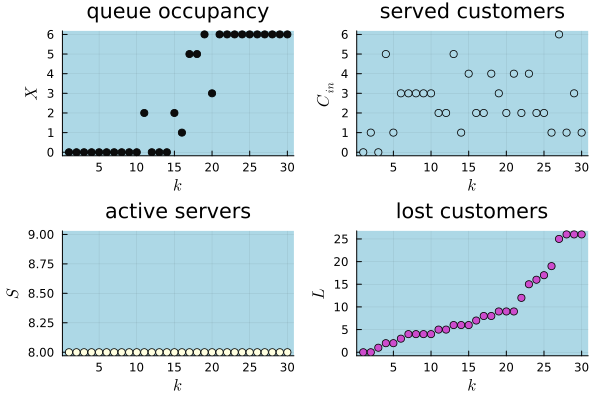

In [451]:
evolution = [X[1:horiz,1], Cin[1:horiz,1], S[1:horiz,1], L[1:horiz,1]]
ylabel = [L"X" L"C_{in}" L"S" L"L"]
title = ["queue occupancy" "served customers" "active servers" "lost customers"]

plotData(evolution, ylabel, title)

In [452]:
println("Total number of served customers: ", Z[horiz+1])
println("Total number of lost customers: ", L[horiz+1])
println("Total cost: ", J)


println("Balking rate: ", sum(L)/sum(L+Z))
println("Total numer of servers used: ", sum(S))

print("c_ser*S + c_blr*B = ", sum(S) + 140*sum(L)/sum(L+Z))

Total number of served customers: 75.00000000000003
Total number of lost customers: 25.99999999999995
Total cost: 3099.999999999995
Balking rate: 0.21877205363443863
Total numer of servers used: 240.0
c_ser*S + c_blr*B = 270.6280875088214